## Data load and preprocess

In [42]:
# !usr/env/python in .env
from load_data import Download_Video
from datetime import datetime
import os
import logging
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# load data
video_num = 10000 # originally, 10000 urls
frame_count = 10
video_time = 10
d = Download_Video(video_num, frame_count, video_time)
tic = datetime.now()
d.download_organizer()
toc = datetime.now()
print('Download time {0}'.format(toc-tic))

In [44]:
# process data
video_num = 10000
frame_count = 10
video_time = 10
d = Download_Video(video_num, frame_count, video_time)
tic = datetime.now()
d.preprocess_organizer()
toc = datetime.now()
print('Process time {0}'.format(toc-tic))

In [45]:
# data check
curr = os.getcwd() + '/datasets/category.npy'
y = np.load(curr)
print('Total number of videos: {0}'.format(y.shape[0]))
if y.shape[0] < video_num:
    print ('There exists invalid video url!')

Total number of videos: 8633
There exists invalid video url!


Average Video Count: 431.65


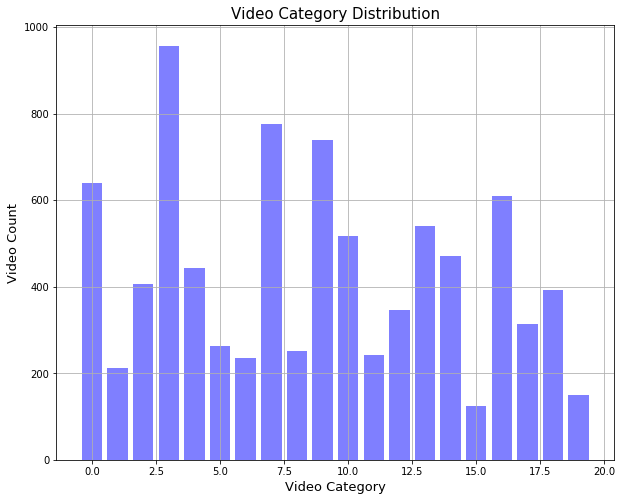

In [43]:
# classes balance check
categories = y[:, 1]
video_dic = Counter(categories)
video_dic = {int(key): value for key, value in video_dic.items()}
cat = list(video_dic.keys())
cat_count = list(video_dic.values())
print('Average Video Count: {0}'.format(sum(cat_count) / float(len(cat_count))))

# plotting
plt.bar(cat, cat_count, align='center',color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Video Category', fontsize = 13)
plt.ylabel('Video Count', fontsize = 13)
plt.title('Video Category Distribution', fontsize = 15)

In [ ]:
# balance data

## Video classification model

### pretrained vgg16 and 3D temporal max pooling

In [1]:
# !usr/env python 3.5 in .env
from pretrained_model import video_classification
from datetime import datetime
import os
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
npy_path = os.getcwd() + '/datasets/'
Xtr_ind = np.load(npy_path + 'x_train_ind_above400.npy')
Xte_ind = np.load(npy_path + 'x_test_ind_above400.npy')
ytr = np.load(npy_path + 'y_train_mapped_above400.npy')
yte = np.load(npy_path + 'y_test_mapped_above400.npy')

assert len(Xtr_ind) == len(ytr)
assert len(Xte_ind) == len(yte)

print('Training sets size: {0}'.format(len(Xtr_ind)))
print('Test sets size: {0}'.format(len(Xte_ind)))
print('Xtrain index shape: ', Xtr_ind.shape)
print('ytrain shape: ', ytr.shape)
print('Xtest index shape: ', Xte_ind.shape)
print('ytest shape: ', yte.shape)

Training sets size: 4270
Test sets size: 1830
Xtrain index shape:  (4270,)
ytrain shape:  (4270,)
Xtest index shape:  (1830,)
ytest shape:  (1830,)


In [3]:
# model

curr_path = os.getcwd()
frame_dir = curr_path + '/datasets/frames'

# set test video num
num_videos = 1000

# fuse features
model = video_classification()
tic = datetime.now()
# features = model.load_features(frame_dir, num_videos)
features = model.load_features_update(Xtr_ind, ytr)
toc = datetime.now()
print('Feature fusion time: ', toc-tic)

100%|██████████| 4270/4270 [24:46<00:00,  2.91it/s]

Feature fusion time:  0:24:46.187513


In [3]:
# save features
np.save(os.getcwd() + '/datasets/pretrained_fuse_features.npy', features)

In [3]:
# train model
Xtr = np.load(os.getcwd() + '/datasets/pretrained_fuse_features.npy')
print('Xtrain shape: ', Xtr.shape)

Xtrain shape:  (4270, 10, 7, 7, 512)


In [4]:
random.seed(100)
model = video_classification()
sgd_m = optimizers.SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
hist = model.train(Xtr, ytr, reg = 0.0001, optimizer = sgd_m, verbose = 1, epochs = 40, split_ratio = 0.2)

Model is Training...
Train on 3416 samples, validate on 854 samples
Epoch 1/40
3416/3416 [==============================] - 17s - loss: 11.8616 - acc: 0.2518 - val_loss: 9.8844 - val_acc: 0.3806
Epoch 2/40
3416/3416 [==============================] - 15s - loss: 9.3722 - acc: 0.4245 - val_loss: 9.0388 - val_acc: 0.4485
Epoch 3/40
3416/3416 [==============================] - 15s - loss: 8.5143 - acc: 0.4725 - val_loss: 8.8818 - val_acc: 0.4567
Epoch 4/40
3416/3416 [==============================] - 15s - loss: 7.6221 - acc: 0.5354 - val_loss: 8.1793 - val_acc: 0.4883
Epoch 5/40
3416/3416 [==============================] - 15s - loss: 7.1757 - acc: 0.5621 - val_loss: 8.6433 - val_acc: 0.4625
Epoch 6/40
3416/3416 [==============================] - 15s - loss: 6.6311 - acc: 0.5987 - val_loss: 8.0193 - val_acc: 0.5176
Epoch 7/40
3416/3416 [==============================] - 15s - loss: 6.2920 - acc: 0.6247 - val_loss: 7.9483 - val_acc: 0.5094
Epoch 8/40
3416/3416 [===========================

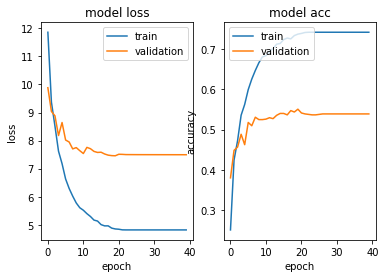

In [5]:
# summarize history for accuracy
model.plot()

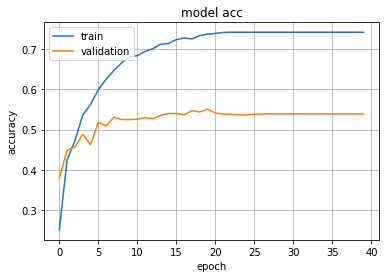

In [15]:
# save figure
hist = model.hist
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
# plt.grid()
# plt.savefig('pretrained_model_loss.png')

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.savefig('pretrained_model_acc.png')

In [11]:
Xte = model.load_features_update(Xte_ind, yte)

100%|██████████| 1830/1830 [10:44<00:00,  2.84it/s]


In [12]:
np.save(os.getcwd() + '/datasets/pretrained_fuse_Xtest.npy', Xte)

In [6]:
Xte = np.load(os.getcwd() + '/datasets/pretrained_fuse_Xtest.npy')
model.predict(Xte, yte)

Video Classification Accuracy: 0.526775956284153


In [20]:
from sklearn.metrics import classification_report
from pprint import pprint
ypred = model.add_model.predict(Xte)
ypred = np.argmax(ypred, axis = 1)
target_names = ['music', 'gaming', 'sports/actions', 'news/events/politics', 'movie/comedy', 'vehicles/autos',\
           'howto', 'animals/pets', 'kids/family', 'food/drink']
print(classification_report(yte, ypred, target_names = target_names))

                      precision    recall  f1-score   support

               music       0.36      0.35      0.36       195
              gaming       0.49      0.59      0.54       122
      sports/actions       0.60      0.71      0.65       288
news/events/politics       0.00      0.00      0.00       133
        movie/comedy       0.40      0.57      0.47       220
      vehicles/autos       0.73      0.72      0.73       229
               howto       0.53      0.48      0.50       163
        animals/pets       0.51      0.54      0.52       145
         kids/family       0.41      0.36      0.38       152
          food/drink       0.65      0.63      0.64       183

         avg / total       0.49      0.53      0.51      1830



/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Counter({0: 215, 2: 327, 3: 133, 4: 318, 5: 220, 6: 176, 7: 186, 9: 255})

In [12]:
# save model
from models import models
m = models(model = model.add_model, model_name = 'temporal_maxpool_model')
m.save()

Unknown
Saved model to disk


### Direct 3D Convolutional 

In [ ]:
from frame_classification_process import frame_process
import numpy as np
import os

curr_path = os.getcwd()
x_train_ind = np.load(curr_path+'/datasets/x_train_ind_above400.npy')
y_train = np.load(curr_path+'/datasets/y_train_mapped_above400.npy')
num_videos = len(y_train)
fp = frame_process(num_videos, size = (80,80,3))
X = fp.process_updates_frameSeq_stacked(x_train_ind, y_train, 10)



## model Test in random data points

In [12]:
# test model train example

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import keras
from keras import regularizers
%matplotlib inline

num_classes = 10
m = Sequential()
m.add(Dense(32, activation='relu', input_dim=100, kernel_regularizer=regularizers.l2(0.01), 
            activity_regularizer=regularizers.l1(0.01)))

m.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
sgd_m = keras.optimizers.SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True)
m.compile(optimizer=sgd_m,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Generate dummy data
import numpy as np
d1 = 5000
d2 = int(d1 * 0.8)
data = np.random.random((d1, 100))
labels = np.random.randint(num_classes, size=(d1, 1))
yte = labels[d2:]
labels = to_categorical(labels, num_classes = num_classes)
ytr = labels[:d2]
Xtr = data[:d2]
Xte = data[d2:]


# Train the model, iterating on the data in batches of 32 samples
history = m.fit(Xtr, ytr, epochs=150, batch_size=32, validation_split = 0.2, verbose = 1)
# list all data in history
print(history.history.keys())
# summarize history for accuracy

# plt.subplots(122)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

Train on 3200 samples, validate on 800 samples
Epoch 1/150
3200/3200 [==============================] - 0s - loss: 3.5305 - acc: 0.9000 - val_loss: 3.5059 - val_acc: 0.9000
Epoch 2/150
3200/3200 [==============================] - 0s - loss: 3.4990 - acc: 0.9000 - val_loss: 3.4745 - val_acc: 0.9000
Epoch 3/150
3200/3200 [==============================] - 0s - loss: 3.4675 - acc: 0.9000 - val_loss: 3.4433 - val_acc: 0.9000
Epoch 4/150
3200/3200 [==============================] - 0s - loss: 3.4363 - acc: 0.9000 - val_loss: 3.4124 - val_acc: 0.9000
Epoch 5/150
3200/3200 [==============================] - 0s - loss: 3.4054 - acc: 0.9000 - val_loss: 3.3818 - val_acc: 0.9000
Epoch 6/150
3200/3200 [==============================] - 0s - loss: 3.3747 - acc: 0.9000 - val_loss: 3.3514 - val_acc: 0.9000
Epoch 7/150
3200/3200 [==============================] - 0s - loss: 3.3442 - acc: 0.9000 - val_loss: 3.3214 - val_acc: 0.9000
Epoch 8/150
3200/3200 [==============================] - 0s - loss: 3.3

KeyboardInterrupt: 

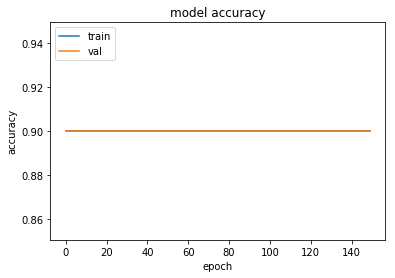

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [10]:
# predict
ypred = m.predict(Xte)
ypred = np.argmax(ypred, axis = 1)
print('Test Accuracy: {0}'.format(np.mean(ypred == yte)))

Test Accuracy: 0.099345


## frame classification

In [7]:
from frame_classification import frame_classification
from frame_classification_process import frame_process
import matplotlib.pyplot as plt
import numpy as np
import os 

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
num_video = 8000
frame_idx = 1
fp = frame_process(num_video, frame_idx)

# raw process with num_video, frame_idx
# X = fp.process_original()

In [3]:
# load balanced datasets index
npy_path = os.getcwd() + '/datasets/'
Xtr_ind = np.load(npy_path + 'x_train_ind_above400.npy')
Xte_ind = np.load(npy_path + 'x_test_ind_above400.npy')
ytr = np.load(npy_path + 'y_train_mapped_above400.npy')
yte = np.load(npy_path + 'y_test_mapped_above400.npy')

assert len(Xtr_ind) == len(ytr)
assert len(Xte_ind) == len(yte)

print('Training sets size: {0}'.format(len(Xtr_ind)))
print('Test sets size: {0}'.format(len(Xte_ind)))
print('Xtrain index shape: ', Xtr_ind.shape)
print('ytrain shape: ', ytr.shape)
print('Xtest index shape: ', Xte_ind.shape)
print('ytest shape: ', yte.shape)

Training sets size: 4270
Test sets size: 1830
Xtrain index shape:  (4270,)
ytrain shape:  (4270,)
Xtest index shape:  (1830,)
ytest shape:  (1830,)


In [4]:
# load train and test from file folders
Xtr = fp.process_updated(Xtr_ind, ytr)
Xte = fp.process_updated(Xte_ind, yte)

100%|██████████| 1830/1830 [00:13<00:00, 132.71it/s]


In [5]:
print('Xtrain shape: ', Xtr.shape)
print('Xtest shape: ', Xte.shape)
num_classes = len(np.unique(ytr))
print('Num of Classes in Training: ', num_classes)

Xtrain shape:  (4270, 224, 224, 3)
Xtest shape:  (1830, 224, 224, 3)
Num of Classes in Training:  10


In [9]:
# hyperparameters
lr = 1e-3
num_classes = num_classes
reg = 0.1
decay = 1e-8

fc = frame_classification(lr, num_classes, reg = reg, decay = decay)

# load true labels
# curr = os.getcwd() + '/datasets/category.npy'
# y = np.load(curr)[:num_video, 1]

# random labels trial
# y = np.random.randint(num_classes, size = (num_video, 1))
Xtr_ex = Xtr[:500]
ytr_ex = ytr[:500]
bsize = 32; epoch = 10; verbose = 1; split_ratio = 0.2
fc.train(Xtr_ex, ytr_ex, bsize, epoch, verbose, split_ratio)

Train on 400 samples, validate on 100 samples
Epoch 1/10
400/400 [==============================] - 14s - loss: 3.9140 - acc: 0.1225 - val_loss: 3.4807 - val_acc: 0.1900
Epoch 2/10
400/400 [==============================] - 8s - loss: 3.2177 - acc: 0.1550 - val_loss: 2.9365 - val_acc: 0.1600
Epoch 3/10
400/400 [==============================] - 8s - loss: 2.7802 - acc: 0.1725 - val_loss: 2.6200 - val_acc: 0.1300
Epoch 4/10
400/400 [==============================] - 8s - loss: 2.5340 - acc: 0.1650 - val_loss: 2.4502 - val_acc: 0.1200
Epoch 5/10
400/400 [==============================] - 8s - loss: 2.4049 - acc: 0.1675 - val_loss: 2.3653 - val_acc: 0.1100
Epoch 6/10
400/400 [==============================] - 8s - loss: 2.3415 - acc: 0.1675 - val_loss: 2.3257 - val_acc: 0.1100
Epoch 7/10
400/400 [==============================] - 8s - loss: 2.3124 - acc: 0.1675 - val_loss: 2.3083 - val_acc: 0.1100
Epoch 8/10
400/400 [==============================] - 8s - loss: 2.2995 - acc: 0.1675 - val_

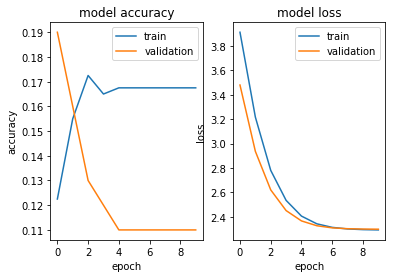

In [10]:
# plot loss and accuracy
fc.plot()

In [ ]:
# test accuracy
fc.predict(Xte, yte)

NameError: name 'sess' is not defined